In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import pmdarima as pm

from datetime import datetime
from matplotlib import pyplot as plt

from statsmodels import api as sm

from statsforecast.models import AutoARIMA

from sklearn.metrics import r2_score, mean_absolute_error
from statsmodels.tsa.stattools import kpss, adfuller
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

from warnings import filterwarnings

filterwarnings("ignore")

/home/grc/arep/time_series/lib/python3.10/site-packages/statsforecast/core.py:25: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
def plot_ts_acf(df, x, y, n_lags=range(1,26)):
    _, _, = plt.subplots(figsize=(12,7))
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((2, 2), (1, 0))
    ax2 = plt.subplot2grid((2, 2), (1, 1));

    sns.lineplot(df, x=x, y=y, color='k', marker='o', ax=ax0)
    plot_acf(df[y].dropna(), lags=n_lags, ax=ax1)
    plot_pacf(df[y].dropna(), lags=n_lags, ax=ax2)

    ax0.set_title('Seasonal Difference')

    for axi in [ax0, ax1, ax2]: axi.grid('on')

    plt.tight_layout();

def plot_ts_resid(df, x, y, n_lags=range(1,10), title=''):
    _, _, = plt.subplots(figsize=(12,7))
    ax0 = plt.subplot2grid((2, 2), (0, 0), colspan=2)
    ax1 = plt.subplot2grid((2, 2), (1, 0))
    ax2 = plt.subplot2grid((2, 2), (1, 1));

    ax0.plot(df[y], marker='o', color='k',)
    #ax0.hlines(0, 2000, df['Resid'].shape[0], color='k', linestyle='--')

    plot_acf(df[y], ax=ax1, lags=n_lags)

    ax2.hist(df[y], bins=len(df) // 4)

    ax0.set_title(title)
    for axi in [ax0, ax1, ax2]: axi.grid('on')

    plt.tight_layout();

### 1.0. Dynamic Regression Models

#### 1.1. Dynamic Regression Models

Os modelos dos dois capítulos anteriores nos possibilitam incluir informações das observações passadas das variáveis, entretanto não possibilitam incluir outras variáveis independentes que podem ajudar na previsão.
Entretanto os modelos de regressão no capítulo 7 nos possibilitaram incluir mais de uma variável, então podemos estender os modelos arima para levar em conta novas variáveis independentes ou variáveis exógenas, entretanto é necessário mudar a equação.


A equação da regressão linear múltipla é dada pela seguinte fórmula:


$y_t = \beta_0 + \beta_1 x_{1,t} + \dots + \beta_k x_{k,t} + \varepsilon_t$


Onde $y_t$ é a variável resposta em uma função linear de $k$ variáveis independentes e o $\varepsilon_t$ é um ruído branco com todas as assumptions apresentadas no capítulo 7.


Para os modelos deste capítulo iremos levar em conta a autocorrelação nos erros da regressão, para enfatizar essa mudança de perspectiva, denotamos $\eta_t$ como erro da regressão agora, ou seja, os erros da regressão abaixo por exemplo seguem um modelo arima(1, 1, 1).


\begin{align*}
 y_t &= \beta_0 + \beta_1 x_{1,t} + \dots + \beta_k x_{k,t} + \eta_t,\\
     & (1-\phi_1B)(1-B)\eta_t = (1+\theta_1B)\varepsilon_t,
\end{align*}


Agora existem 2 termos de erro, o erro da regressão e o erro do modelo arima denotado por $\varepsilon_t$, apenas os erros do modelo arima são assumidos como white noise. Entretanto, não podemos minimizar os erros levando em conta a $\sum \eta_t^2$, isso causa alguns problemas na hora de estimar os betas relacionados a problemas de estacionariedade nos dados e a estimação do p-valor dos coeficientes.


Precisamos que todas as variáveis utilizadas sejam estacionárias, caso contrário os coeficientes estimados poderão estar incorretos, e a diferenciação pode ser aplicada em todas as variáveis para torná-las estacionárias.


Por exemplo, em R `ARIMA(y ~ x + pdq(1,1,0))` pode ser representada em python como `pm.ARIMA(order=(1,1,0)).fit(y, x)` e matematicamente com a seguinte fórmula: $y_t' = \beta_1 x'_t + \eta'_t$ onde $\eta'_t = \phi_1 \eta'_{t-1} + \varepsilon_t$, AR(1) que é equivalente a: $y_t = \beta_0 + \beta_1 x_t + \eta_t$ e $\eta_t$ é o erro ARIMA(1, 1, 0).

Podemos usar a classe ARIMA da bilbioteca pmdarima e especificar no método fit as variáveis exogenas. No livro é feito um arima automático e obtido a ordem p, d, q sendo (1, 0, 2) e sem ordens sazonais.

Para reprlicar os mesmo valores do livro utilize a classe sem ser a versão automática (auto_arima) para reproduzir exatamente os mesmos valores do livro só que no python.

#### 1.2. Us Changes

In [76]:
df = pd.read_csv("../data/us_change.csv", index_col=[0])
df['Quarter'] = df['Quarter'].apply(lambda x: x.replace(' ', '-'))
df['Quarter'] = pd.PeriodIndex(df['Quarter'], freq='Q').to_timestamp()

<Axes: xlabel='Quarter'>

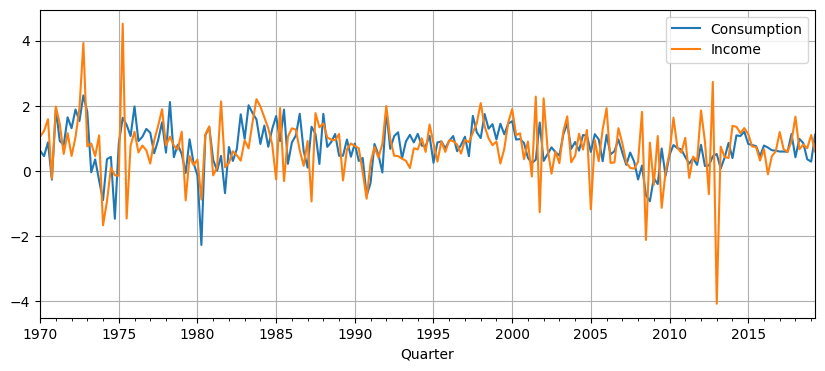

In [78]:
df[["Quarter", "Consumption", "Income"]].plot(
    x="Quarter", figsize=(10, 4), grid=2
)

In [77]:
df.head()

,Quarter,Consumption,Income,Production,Savings,Unemployment
1,1970-01-01,0.618566,1.044801,-2.452486,5.299014,0.9
2,1970-04-01,0.451984,1.225647,-0.551459,7.789894,0.5
3,1970-07-01,0.872872,1.585154,-0.358652,7.403984,0.5
4,1970-10-01,-0.271848,-0.239545,-2.185691,1.169898,0.7
5,1971-01-01,1.901345,1.975925,1.909764,3.535667,-0.1


No livro, é obtido os seguintes resultados:

\begin{align*}
  y_t &= 0.595 +
         0.198 x_t + \eta_t, \\
  \eta_t &= 0.707 \eta_{t-1} + \varepsilon_t
        -0.617 \varepsilon_{t-1} +
        0.207 \varepsilon_{t-2},\\
  \varepsilon_t &\sim \text{NID}(0,0.311).
\end{align*}

Na versão desenvolvida em python com os mesmos parâmetros:

\begin{align*}
  y_t &= 0.174 +
         0.198 x_t + \eta_t, \\
  \eta_t &= 0.707 \eta_{t-1} + \varepsilon_t
        -0.617 \varepsilon_{t-1} +
        0.207 \varepsilon_{t-2},\\
  \varepsilon_t &\sim \text{NID}(0,0.3035).
\end{align*}

Por fim, utilizando o auto_arima, obtime o seguinte modelo:

\begin{align*}
  y_t &= 0.29 +
         0.18 x_t + \eta_t, \\
  \eta_t &= 0.10 \eta_{t-1} +
        0.22 \eta_{t-2} +
        0.18 \eta_{t-3} + \varepsilon_t,\\
  \varepsilon_t &\sim \text{NID}(0,0.3025).
\end{align*}

In [25]:
a = pm.ARIMA(
    order=(1, 0, 2),
    seasonal_order=(0, 0, 0, 0)
).fit(
    y=df[["Consumption"]],
    X=df[["Income"]]
)

a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  198
Model:               SARIMAX(1, 0, 2)   Log Likelihood                -163.036
Date:                Tue, 26 Dec 2023   AIC                            338.072
Time:                        13:57:24   BIC                            357.802
Sample:                             0   HQIC                           346.058
                                - 198                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1742      0.062      2.788      0.005       0.052       0.297
Income         0.1976      0.034      5.855      0.000       0.131       0.264
ar.L1          0.7071      0.106      6.659      0.000       0.499       0.915
ma.L1         -0.6173      0.113     -5.470      0.000      -0.839      -0.396
ma.L2          0.2066      0.065      3.174      0.002       0.079       0.334
sigma2         0.3035      0.022     13.525      0.000       0.260       0.347
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                45.83
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Com o método resid, obtemos os resíduos de inovação.

In [35]:
df["resid"] = a.resid()

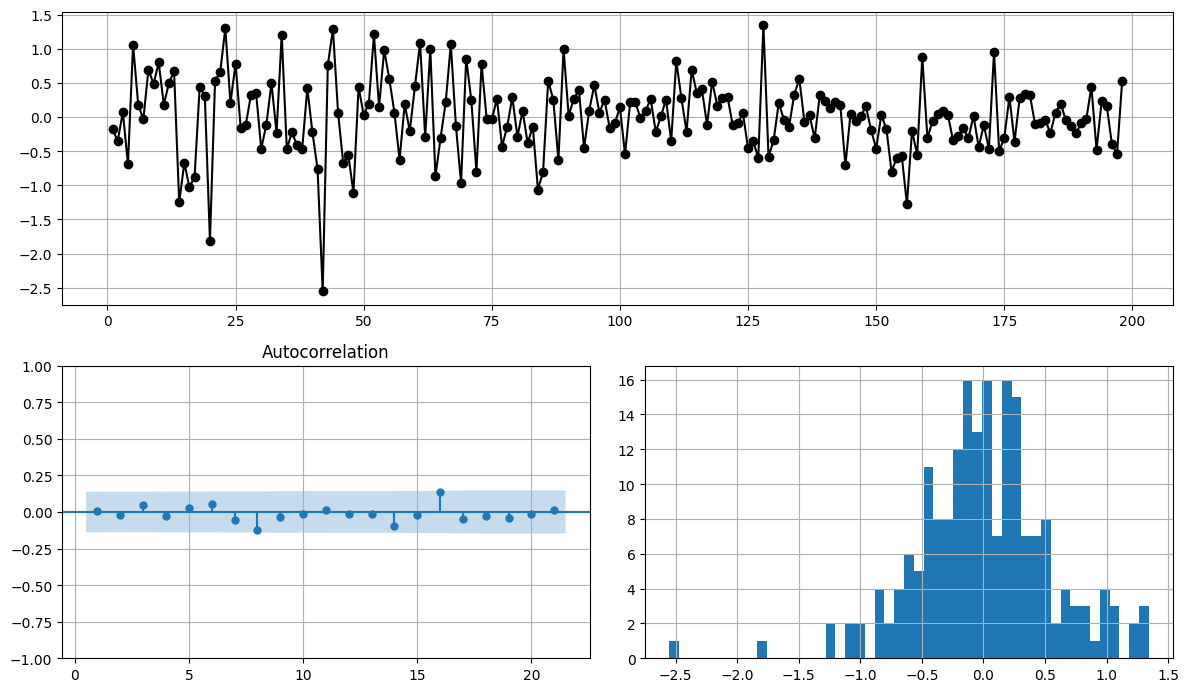

In [38]:
plot_ts_resid(df, "Quarter", "resid", n_lags=range(1, 22))

In [66]:
b = pm.auto_arima(
    y=df[["Consumption"]],
    X=df[["Income"]],
    test="kpss",
    stepwise=False
)

b.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  198
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -162.727
Date:                Tue, 26 Dec 2023   AIC                            337.454
Time:                        15:26:00   BIC                            357.183
Sample:                             0   HQIC                           345.440
                                - 198                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2906      0.055      5.326      0.000       0.184       0.398
Income         0.1861      0.034      5.429      0.000       0.119       0.253
ar.L1          0.1081      0.065      1.664      0.096      -0.019       0.236
ar.L2          0.2267      0.060      3.756      0.000       0.108       0.345
ar.L3          0.1836      0.060      3.064      0.002       0.066       0.301
sigma2         0.3025      0.022     13.542      0.000       0.259       0.346
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                52.60
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               0.27   Skew:                            -0.47
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Agora, para prever o futuro, precisamos prever todas as variáveis independentes no futuro também!!

No exemplo abaixo é apenas os valores ajustados levando em comta, x, y e o yhat.

<Axes: xlabel='Quarter'>

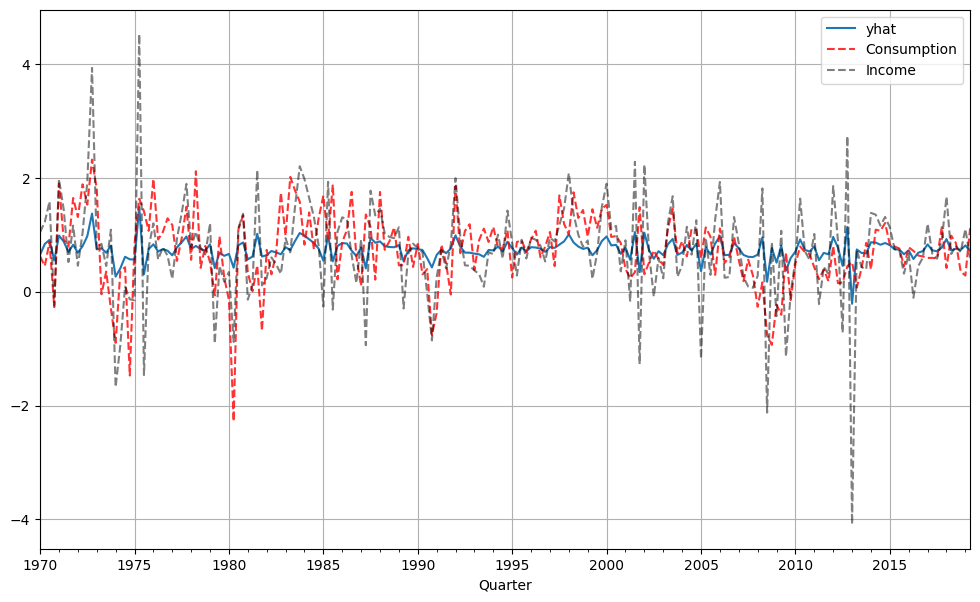

In [63]:
df["yhat"] = a.predict(n_periods=len(df), X=df[["Income"]]).values

ax = df[["Quarter", "yhat"]].plot(x="Quarter", figsize=(12, 7))
ax = df[["Quarter", "Consumption"]].plot(x="Quarter", ax=ax, grid=2, linestyle="--", color='r', alpha=0.8)
df[["Quarter", "Income"]].plot(x="Quarter", ax=ax, grid=2, linestyle="--", color='k', alpha=0.5)

Agora para a previsão do futuro, preciso gerar a previsão do income para o futuro, então vou usar um modelo arima bem simples automaticamente selecionado a fim de prever o futuro da variável income para usar no modelo original como variável independente para prever o consumption.

In [93]:
income_arima = pm.auto_arima(
    y=df.Income,
    stepwise=False
)

income_arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  198
Model:               SARIMAX(2, 0, 3)   Log Likelihood                -251.484
Date:                Tue, 26 Dec 2023   AIC                            516.968
Time:                        15:40:06   BIC                            539.986
Sample:                             0   HQIC                           526.285
                                - 198                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4249      0.112      3.796      0.000       0.205       0.644
ar.L1          1.1596      0.140      8.283      0.000       0.885       1.434
ar.L2         -0.7437      0.128     -5.805      0.000      -0.995      -0.493
ma.L1         -1.2992      0.145     -8.956      0.000      -1.584      -1.015
ma.L2          1.0763      0.126      8.564      0.000       0.830       1.323
ma.L3         -0.2086      0.079     -2.627      0.009      -0.364      -0.053
sigma2         0.7409      0.049     15.168      0.000       0.645       0.837
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               207.04
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               0.92   Skew:                            -0.30
Prob(H) (two-sided):                  0.75   Kurtosis:                         7.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

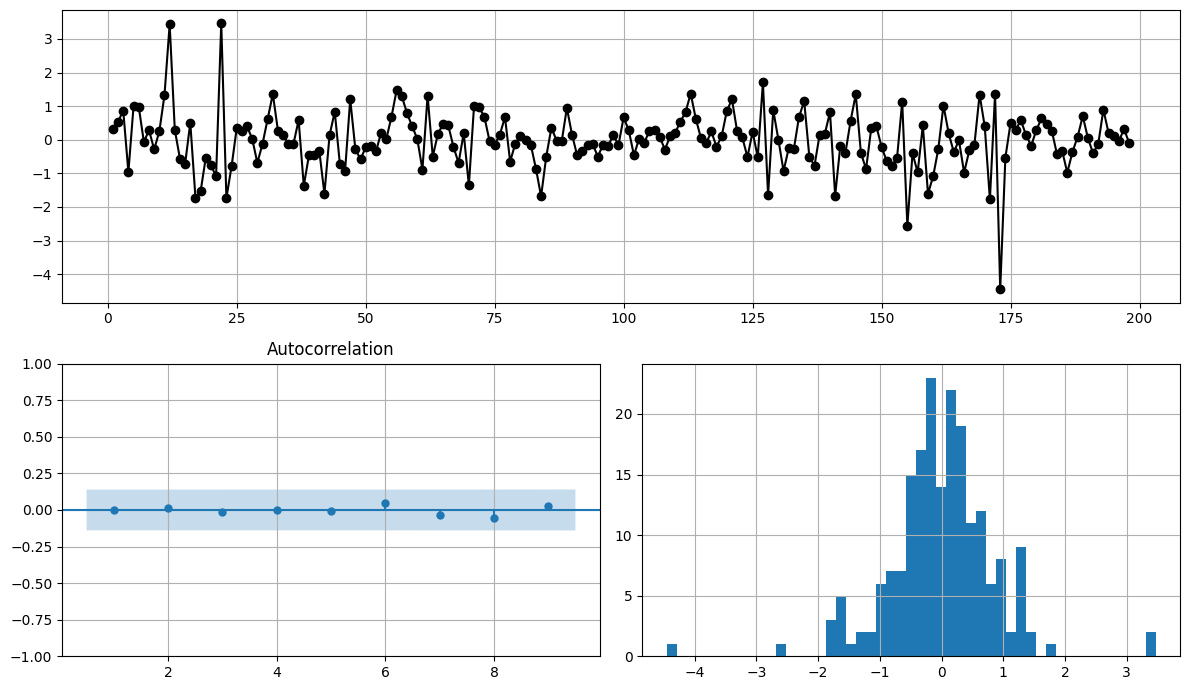

In [94]:
df["income_arima_resid"] = income_arima.resid()

plot_ts_resid(df, x="Quarter", y="income_arima_resid")

Dataset para o futuro com as previsões de Income geradas pelo auto_arima.

In [144]:
forecast = pd.DataFrame(
    pd.date_range(
        start=df.Quarter.max(),
        end=df.Quarter.max() + pd.offsets.DateOffset(years=4),
        freq="QS-DEC"
    )
).rename(columns={0:"Quarter"})

forecast["Income"] = income_arima.predict(n_periods=len(forecast)).values

In [145]:
forecast.head()

,Quarter,Income
0,2019-06-01,0.778385
1,2019-09-01,0.713552
2,2019-12-01,0.693817
3,2020-03-01,0.698750
4,2020-06-01,0.719146


Por fim, agora utilizando o Dataset do futuro para prever o Consumption.

In [146]:
f, confs = a.predict(
    n_periods=len(forecast),
    X=forecast[["Income"]],
    return_conf_int=True,
    alpha=0.05
)

forecast["Consumption"] = f.values
forecast["lower"] = confs[:, 0]
forecast["upper"] = confs[:, 1]

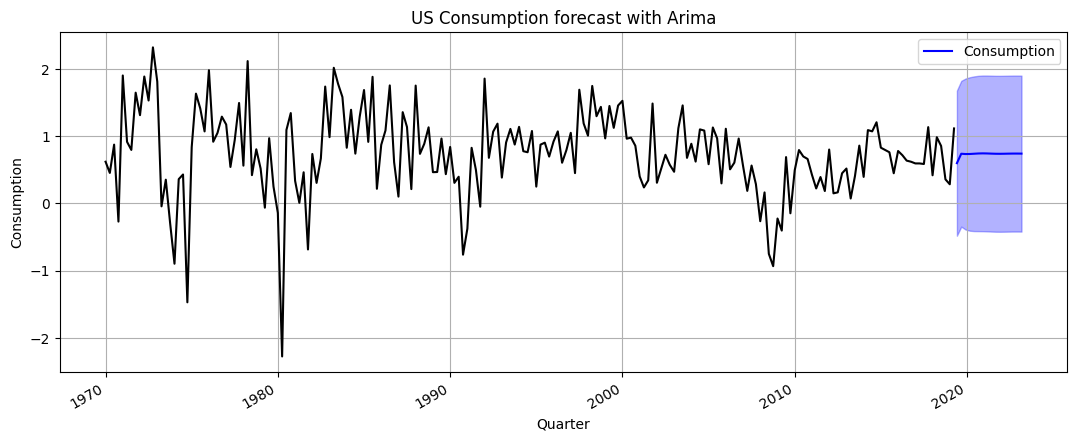

In [147]:
fig, ax = plt.subplots(figsize=(13, 5))
sns.lineplot(df, x="Quarter", y="Consumption", color="k")
ax.fill_between(forecast["Quarter"], forecast["lower"], forecast["upper"], alpha=0.3, color="b")
forecast.plot(x="Quarter", y="Consumption", color="b", linestyle="-", ax=ax)
ax.set_title("US Consumption forecast with Arima")
ax.grid(2)

#### 1.3. Vic Eletricity

Esse é mais um exemplo do livro, o objetivo é prever a demanda em função da temperature onde podemos observar alguns padrões como em dias de semana e finais de semana que pode ser uma variável independente e também devido a temperatura que é outra variável independente que conseguimos observar padrões como consumo de energia no inverno dado a o uso de aquecedores e consumo de energia no verão dado o uso de ar condicionado.

In [231]:
df = pd.read_csv("../data/vic_elec.csv", index_col=[0])

df["Date"] = pd.to_datetime(df["Date"])

df = df[df["Date"].dt.year == 2014].reset_index(drop=True)

df = df[["Date", "Demand", "Temperature", "Holiday"]].groupby("Date").agg(
    Demand=("Demand", "sum"),
    Temperature=("Temperature", "max"),
    Holiday=("Holiday", "any")
).reset_index()

df["Day_Type"] = df.apply(
    lambda x: "Holiday" if x["Holiday"] == True else
              "Weekend" if x["Date"].weekday() in [5, 6] else
              "Weekday", axis=1
)

df["Demand"] = df["Demand"] / 1e3

df.head()

,Date,Demand,Temperature,Holiday,Day_Type
0,2014-01-01,175.184962,26.0,True,Holiday
1,2014-01-02,188.350596,23.0,False,Weekday
2,2014-01-03,189.085561,22.2,False,Weekday
3,2014-01-04,173.797587,20.3,False,Weekend
4,2014-01-05,169.732848,26.1,False,Weekend


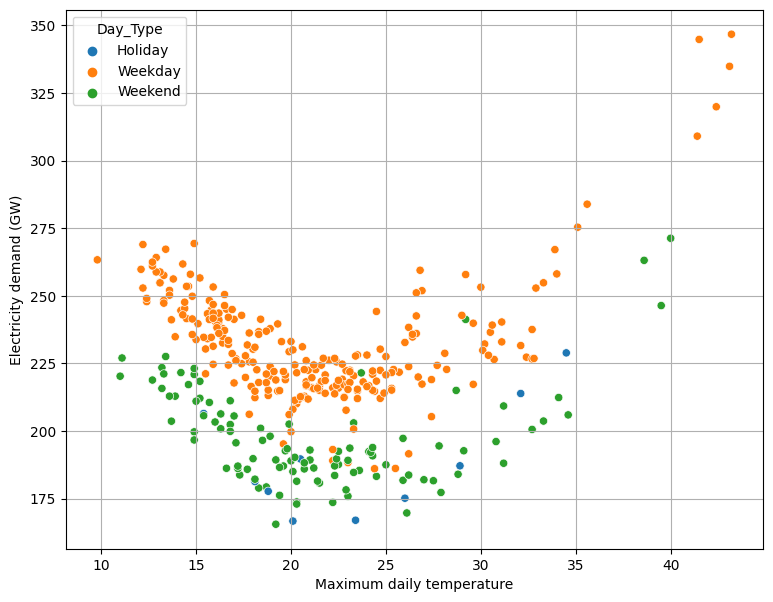

In [233]:
fig, ax = plt.subplots(figsize=(9, 7))
sns.scatterplot(df, x="Temperature", y="Demand", hue="Day_Type")
ax.set_ylabel("Electricity demand (GW)")
ax.set_xlabel("Maximum daily temperature")
ax.grid(2)

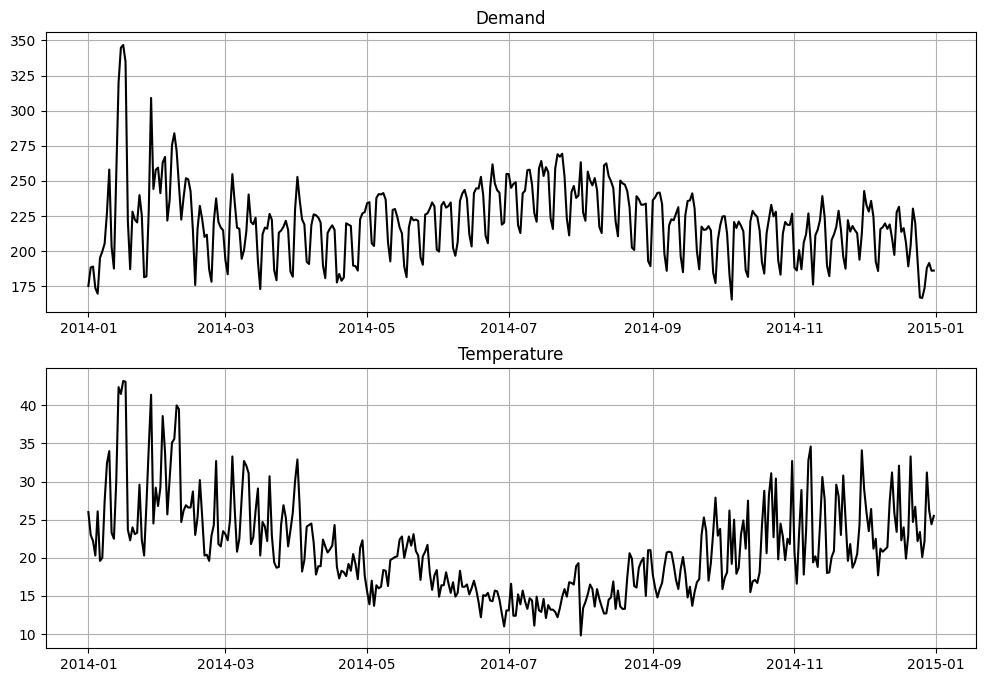

In [234]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
ax[0].plot(df["Date"], df["Demand"], "k")
ax[1].plot(df["Date"], df["Temperature"], "k")
for axi, l in zip(ax, ["Demand", "Temperature"]): axi.grid(2); axi.set_title(l)

No livro é filtrado apenas o Day Type igual a Weekday e as duas variáveis independentes são a temperatura ao quadrado para pegar o efeito do scatterplot e a temperatura sem nenhuma transformação.

In [250]:
dft = df.loc[df["Day_Type"] == "Weekday", ["Date", "Demand", "Temperature"]].reset_index(drop=True)

dft["Temperature2"] = dft["Temperature"] ** 2

dft.head()

,Date,Demand,Temperature,Temperature2
0,2014-01-02,188.350596,23.0,529.00
1,2014-01-03,189.085561,22.2,492.84
2,2014-01-06,195.241082,19.6,384.16
3,2014-01-07,199.770461,20.0,400.00
4,2014-01-08,205.338867,27.4,750.76


Existe o Arima utilizando uma fórmula também igual no livro mas não esta "implementado". Então peguei as mesmas ordem apresentadas no livro, SARIMA(2, 1, 2)(2, 0, 0, 7) com duas variáveis independentes.

In [251]:
# Not Implemented Error
#a = sm.tsa.ARIMA.from_formula(
#    'Demand ~ Temperature + np.power(Temperature, 2) + (Day_Type == "Weekday")',
#    df
#)

In [252]:
a = pm.ARIMA(
    order=(2, 1, 2),
    seasonal_order=(2, 0, 0, 7)
).fit(
    y=dft[["Demand"]],
    X=dft[["Temperature2", "Temperature"]]
)

a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  251
Model:             SARIMAX(2, 1, 2)x(2, 0, [], 7)   Log Likelihood                -849.586
Date:                            Tue, 26 Dec 2023   AIC                           1719.172
Time:                                    16:48:44   BIC                           1754.387
Sample:                                         0   HQIC                          1733.345
                                            - 251                                         
Covariance Type:                              opg                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
intercept       -0.0083      0.167     -0.049      0.961      -0.335       0.319
Temperature2     0.1968      0.011     17.584      0.000       0.175       0.219
Temperature     -8.3918      0.632    -13.282      0.000      -9.630      -7.153
ar.L1           -0.0386      0.625     -0.062      0.951      -1.263       1.186
ar.L2            0.3604      0.436      0.827      0.408      -0.494       1.215
ma.L1           -0.1423      0.617     -0.231      0.818      -1.351       1.067
ma.L2           -0.5456      0.529     -1.031      0.303      -1.583       0.492
ar.S.L7         -0.1648      0.072     -2.284      0.022      -0.306      -0.023
ar.S.L14        -0.0091      0.083     -0.110      0.912      -0.171       0.153
sigma2          52.0779      3.584     14.533      0.000      45.054      59.102
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):               130.49
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.70   Skew:                             0.60
Prob(H) (two-sided):                  0.10   Kurtosis:                         6.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

A primeira linha vem um resíduo muito grande, então estou pulando ela para deixar bem similar ao livro.

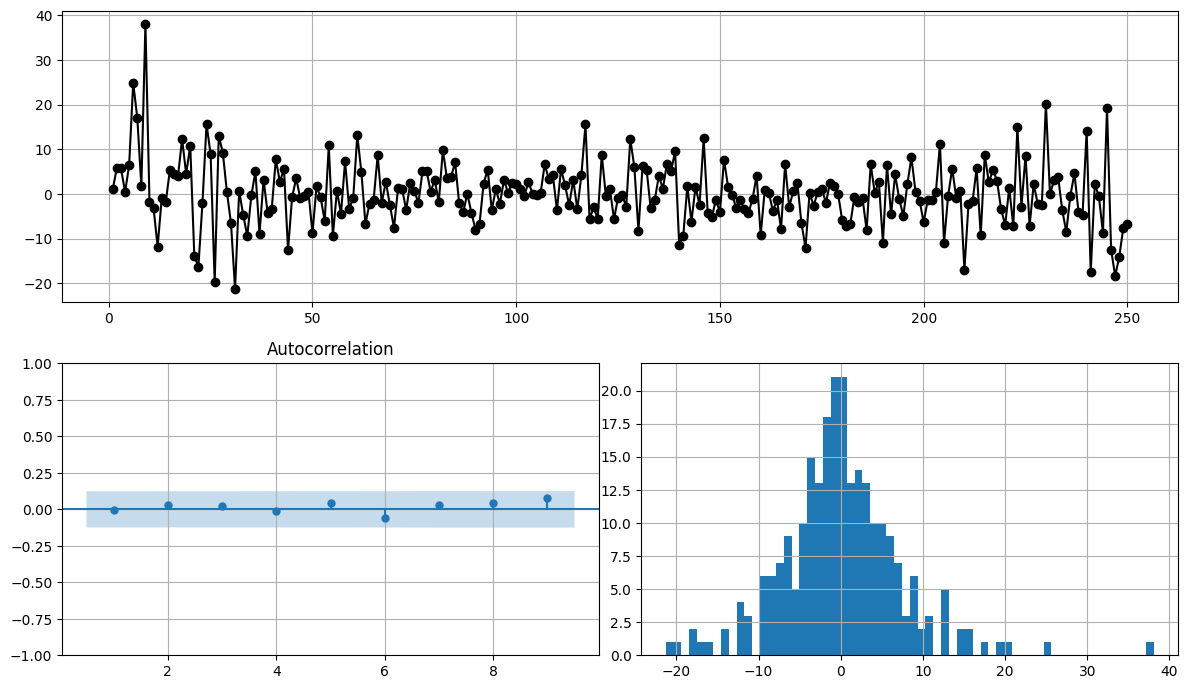

In [253]:
dft["resid"] = a.resid()

plot_ts_resid(dft.iloc[1:, :], "Date", "resid")

Agora se eu quiser fazer as previsões da variável `Demand`, preciso prever o próximo valor máximo da temperatura para os proximos dias e utilizar no modelo Arima treinado anteriormente.

#### 1.4. Stochastic & Deterministic Trend

A tendência deterministica é obtida pelo modelo de regressão. Já a tendência estocástica é obtida caso o modelo possua uma diferenciação no componente d que seja maior que 1.

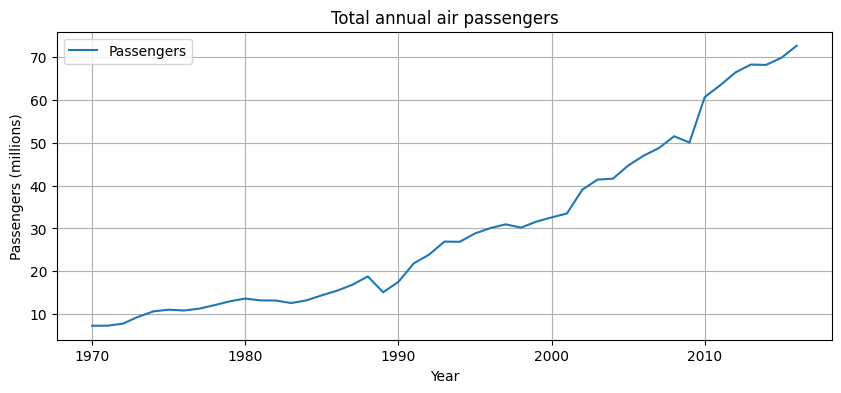

In [259]:
df = pd.read_csv("../data/aus_airpassengers.csv", index_col=[0])

df.plot(x="Year", y="Passengers", figsize=(10, 4), grid=2, ylabel="Passengers (millions)", title="Total annual air passengers");

Vou ter que prever essa tendência para o futuro também.

In [313]:
df["Trend"] = df["Passengers"].rolling(5).mean()

df.dropna(inplace=True)

In [315]:
fit_deterministic = pm.auto_arima(
    y=df[["Passengers"]],
    X=df[["Trend"]],
    max_d=0,
    max_D=0,
    D=0,
    d=0
)

fit_deterministic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   41
Model:               SARIMAX(2, 0, 1)   Log Likelihood                 -74.661
Date:                Tue, 26 Dec 2023   AIC                            161.321
Time:                        17:37:15   BIC                            171.603
Sample:                             0   HQIC                           165.065
                                 - 41                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0310      0.150      0.206      0.836      -0.264       0.326
Trend          1.0992      0.019     57.643      0.000       1.062       1.137
ar.L1          1.3391      0.243      5.505      0.000       0.862       1.816
ar.L2         -0.6165      0.231     -2.666      0.008      -1.070      -0.163
ma.L1         -0.9873      1.220     -0.809      0.418      -3.379       1.404
sigma2         2.1970      2.465      0.891      0.373      -2.634       7.028
===================================================================================
Ljung-Box (L1) (Q):                   0.12   Jarque-Bera (JB):                25.22
Prob(Q):                              0.73   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                             0.67
Prob(H) (two-sided):                  0.12   Kurtosis:                         6.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [271]:
fit_stochastic = pm.auto_arima(
    y=df[["Passengers"]],
    d=1
)

fit_stochastic.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   45
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 -94.517
Date:                Tue, 26 Dec 2023   AIC                            193.035
Time:                        17:30:00   BIC                            196.603
Sample:                             0   HQIC                           194.358
                                 - 45                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.4728      0.377      3.907      0.000       0.734       2.212
sigma2         4.2989      0.518      8.304      0.000       3.284       5.314
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):               113.80
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               7.07   Skew:                             1.69
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Vou prever a tendência no futuro, para os proximos anos para utilizar para as comparações das duas tendências.

In [318]:
trend_forecast = pm.auto_arima(y=df["Trend"])
trend_forecast.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   41
Model:               SARIMAX(0, 2, 0)   Log Likelihood                 -31.457
Date:                Tue, 26 Dec 2023   AIC                             64.914
Time:                        17:38:16   BIC                             66.577
Sample:                             0   HQIC                            65.511
                                 - 41                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.2938      0.045      6.601      0.000       0.207       0.381
===================================================================================
Ljung-Box (L1) (Q):                   0.21   Jarque-Bera (JB):                12.53
Prob(Q):                              0.65   Prob(JB):                         0.00
Heteroskedasticity (H):               4.83   Skew:                            -0.50
Prob(H) (two-sided):                  0.01   Kurtosis:                         5.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [340]:
future_years = [i for i in range(df.Year.max() + 1, df.Year.max() + 21)]

forecast, confs = fit_deterministic.predict(
    20,
    X=pd.DataFrame(
        trend_forecast.predict(20)
    ).reset_index(drop=True).rename(columns={0: "Trend"}),
    return_conf_int=True,
    alpha=0.05
)

forecast_deterministic = pd.DataFrame(
    {"Year": future_years,
     #"Trend": trend_forecast.predict(20).values,
     "Passengers": forecast.values,
     "lower": confs[:, 0],
     "upper": confs[:, 1]}
)

forecast_deterministic.head()

,Year,Passengers,lower,upper
0,2017,77.255531,74.332050,80.179012
1,2018,81.111253,78.000542,84.221965
2,2019,83.966169,80.833908,87.098431
3,2020,85.975412,82.635865,89.314958
4,2021,87.469221,83.877805,91.060637


In [341]:
forecast, confs = fit_stochastic.predict(20, return_conf_int=True, alpha=0.05)

future_years = [i for i in range(df.Year.max() + 1, df.Year.max() + 21)]

forecast_stochastic = pd.DataFrame(
    {"Year": future_years,
     "Passengers": forecast,
     "lower": confs[:, 0],
     "upper": confs[:, 1]}
)

forecast_stochastic.head()

,Year,Passengers,lower,upper
45,2017,74.070476,70.006707,78.134245
46,2018,75.543251,69.796213,81.290288
47,2019,77.016026,69.977371,84.054681
48,2020,78.488801,70.361262,86.616339
49,2021,79.961576,70.874712,89.048440


Não ficou igual o livro pois tem que entender como que o método trend() funciona por debaixo dos panos em R.

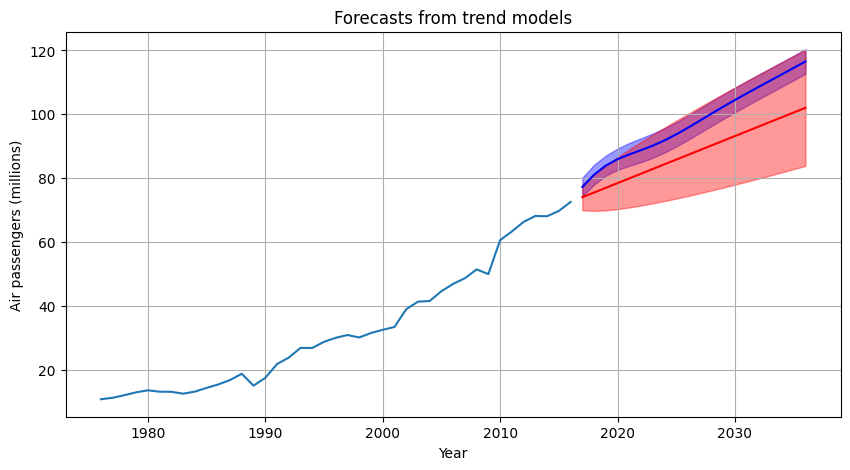

In [343]:
fig, ax = plt.subplots(figsize=(10, 5))
df.plot(x="Year", y="Passengers", ax=ax, legend=None)
forecast_stochastic.plot(x="Year", y="Passengers", ax=ax, color="r", legend=None)
forecast_deterministic.plot(x="Year", y="Passengers", ax=ax, color="b", legend=None)
ax.fill_between(forecast_deterministic["Year"], forecast_deterministic["lower"], forecast_deterministic["upper"], color='b', alpha=0.4)
ax.fill_between(forecast_stochastic["Year"], forecast_stochastic["lower"], forecast_stochastic["upper"], color='r', alpha=0.4)
ax.set_title("Forecasts from trend models")
ax.set_ylabel("Air passengers (millions)")
ax.grid(2);

#### 1.5. Dynamic Harmonic Regression

Quando existem longos períodos sazonais, os modelos de séries temporais utilizando as séries de fourier são melhores do que os modelos apresentados até agora.


Por exemplo, dados diários possuem uma sazonalidade anual de 356, dados semanais possuem um período sazonal aproximadamente a 52, já dados de meia em meia hora possuem muitos períodos sazonais, o menor é a sazonalidade diária, com um padrão de período igual a 48.


Os modelos sazonais do Arima e Ets foram desenvolvidos levando em conta poucos períodos sazonais, como por exemplo dados mensais, já o Ets possui uma restrição de no máximo um período sazonal igual a 24.


Para essas séries é preferível um utilizar modelos chamados "regressão harmônica" onde o padrão sazonal é modelado por séries de fourier que são dinamicamente manipulados pelo erro dos modelos ARMA.


Existe algumas vantagens de utilizar esses modelos, como algumas que o livro aborda são:


1. Possibilita sazonalidade de qualquer tamanho.
2. Séries de fourier com diferentes frequências podem ser incluídas.
3. A suavização do padrão sazonal é controlado pelo parâmetro $K$ que é o número de séries de fourier para o par de senos e cossenos.
4. ARMA pode manipular os erros dinamicamente.


A única desvantagem é que é assumido que o período sazonal é fixo, ou seja, o padrão sazonal não pode mudar ao longo do tempo.


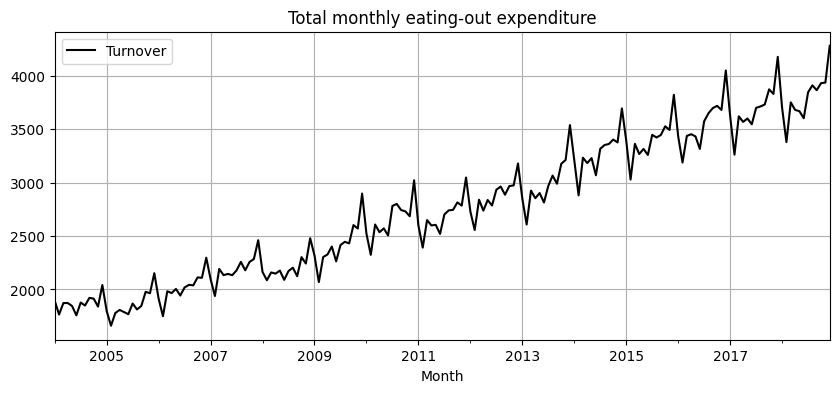

In [23]:
df = pd.read_csv("../data/aus_retail.csv", index_col=[0])

df["Month"] = pd.to_datetime(df["Month"], format="%Y %b")

df = df[df["Industry"] == "Cafes, restaurants and takeaway food services"]
df = df[df["Month"].dt.year.isin(range(2004, 2019))].reset_index(drop=True)

df = df[["Month", "Turnover"]].groupby("Month").sum().reset_index()

df.plot(x="Month", figsize=(10, 4), grid=2, color="k", title="Total monthly eating-out expenditure");

In [132]:
forecast = pd.DataFrame(
    pd.date_range(
        start=df.Month.max(),
        end=df.Month.max() + pd.offsets.DateOffset(years=2),
        freq="MS"    
    )[1:]
).rename(columns={0:"Month"})

In [83]:
u = sm.tsa.UnobservedComponents(
    endog=df["Turnover"].to_numpy(),
    level=True,
    trend=True,
    freq_seasonal=[
        {"period": 12,
         "harmonics": 1}
    ]
).fit(disp=0)

f = u.get_forecast(steps=len(forecast))
fs, confs = f.predicted_mean, f.conf_int(alpha=0.05)

forecast["Turnover"] = f.predicted_mean
forecast["lower"], forecast["upper"] = confs[:, 0], confs[:, 1]

Utiliando um K igual a 6, já é saturado. 

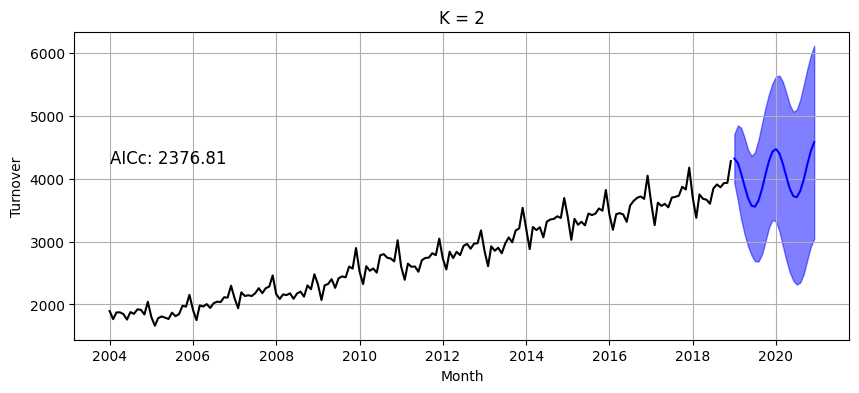

In [131]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=df, x="Month", y="Turnover", ax=ax, color="k")
sns.lineplot(data=forecast, x="Month", y="Turnover", ax=ax, color="b")
ax.fill_between(forecast["Month"], forecast["lower"], forecast["upper"], color="b", alpha=.5)
ax.set_title(f"K = {2}")
ax.text(
    x=ax.get_xaxis().get_data_interval()[0],
    y=4250,
    s=f"AICc: {u.aicc:.2f}",
    fontsize=12
)
ax.grid(2)

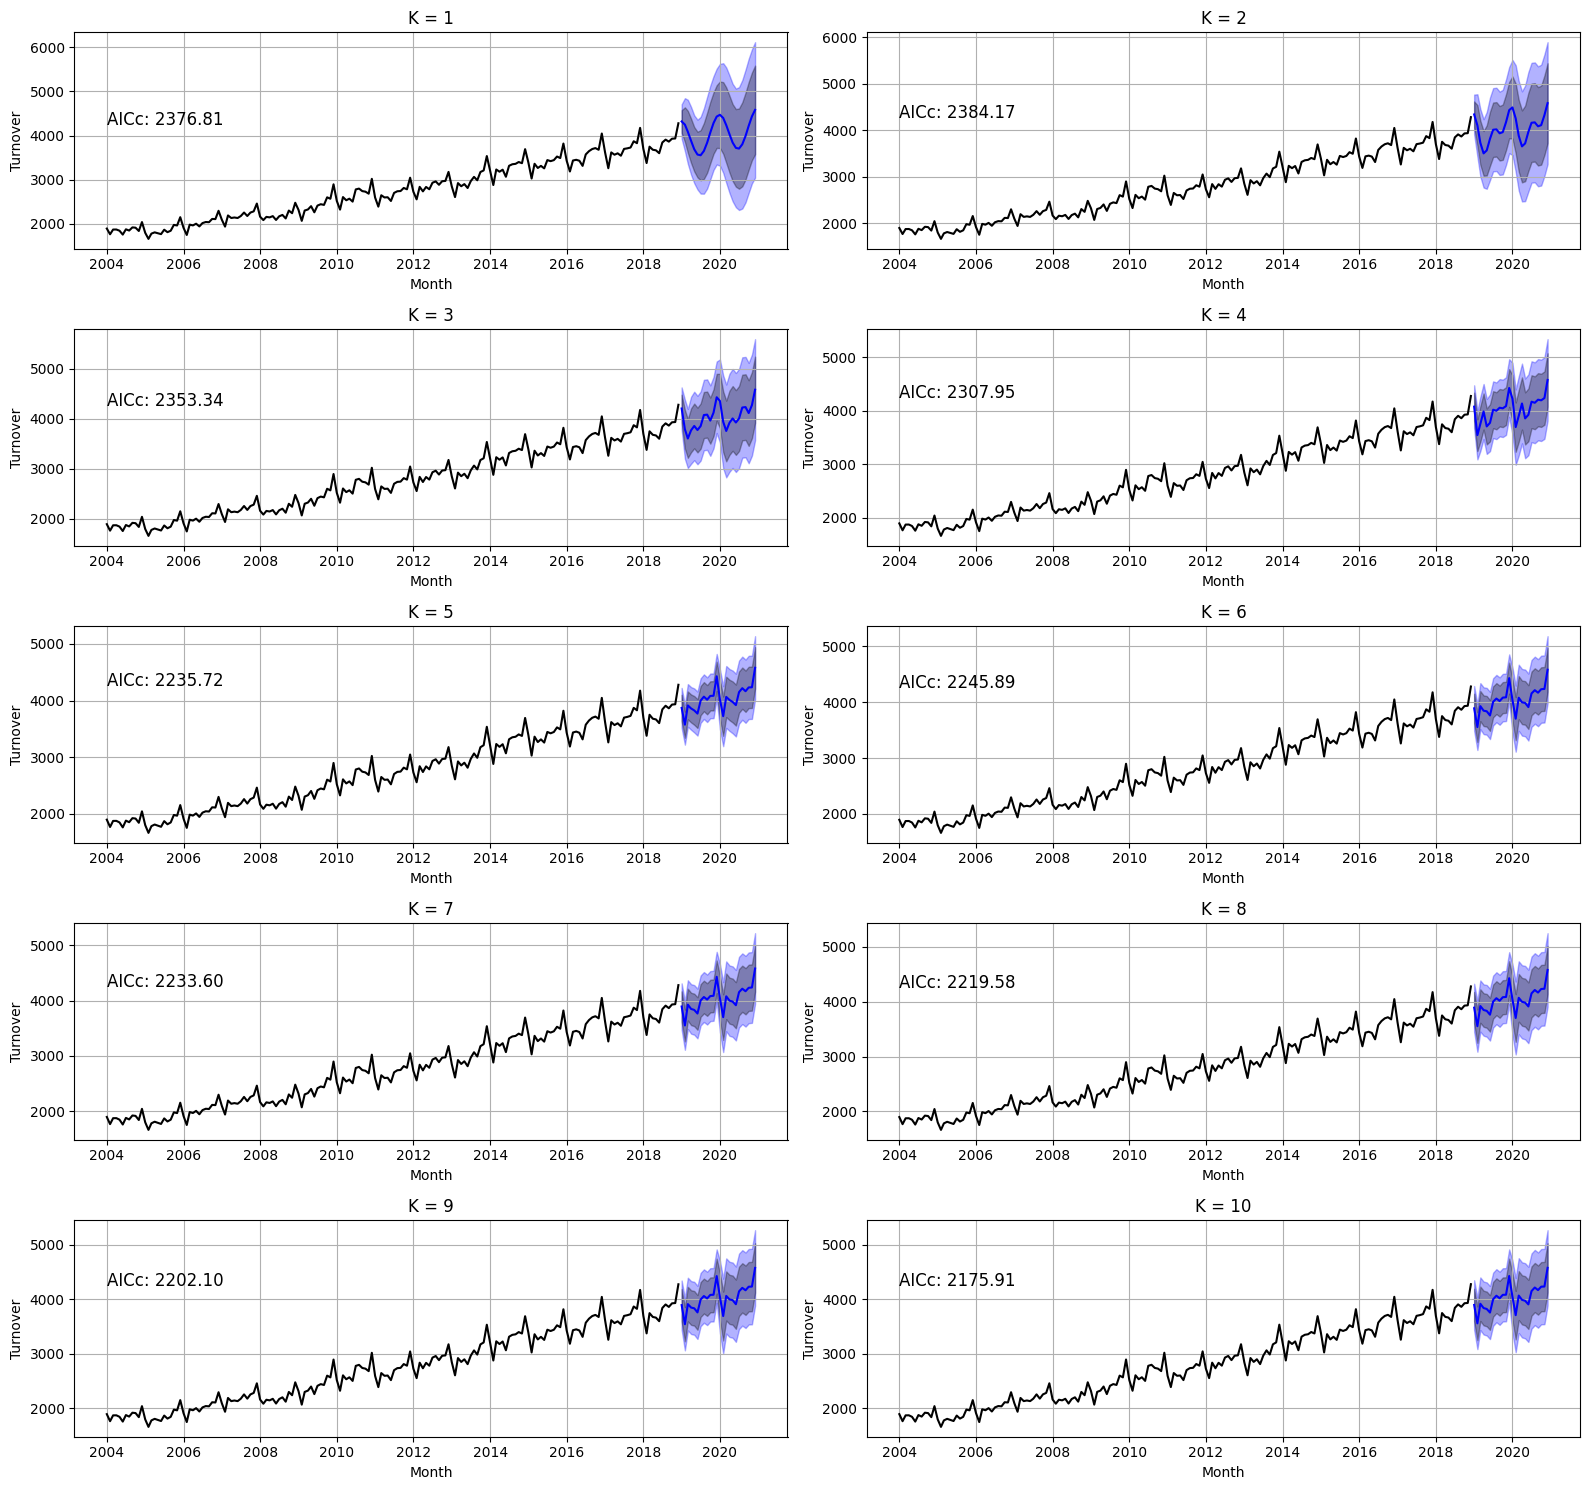

In [152]:
fig, ax = plt.subplots(5, 2, figsize=(16, 15))
ax = ax.flatten()

for axi, k in zip(ax, range(1, len(ax) + 1)):
    u = sm.tsa.UnobservedComponents(
        endog=df["Turnover"].to_numpy(),
        level=True,
        trend=True,
        freq_seasonal=[
            {"period": 12,
            "harmonics": k}
        ]
    ).fit(disp=0)

    f = u.get_forecast(steps=len(forecast))
    fs, confs = f.predicted_mean, f.conf_int(alpha=0.05)
    fs2, confs2 = f.predicted_mean, f.conf_int(alpha=0.2)

    forecast["Turnover"] = f.predicted_mean
    forecast["lower-95"], forecast["upper-95"] = confs[:, 0], confs[:, 1]
    forecast["lower-95"], forecast["upper-95"] = confs[:, 0], confs[:, 1]
    forecast["lower-80"], forecast["upper-80"] = confs2[:, 0], confs2[:, 1]
    forecast["lower-80"], forecast["upper-80"] = confs2[:, 0], confs2[:, 1]

    sns.lineplot(data=df, x="Month", y="Turnover", ax=axi, color="k")
    sns.lineplot(data=forecast, x="Month", y="Turnover", ax=axi, color="b")
    axi.fill_between(forecast["Month"], forecast["lower-95"], forecast["upper-95"], color="b", alpha=.3)
    axi.fill_between(forecast["Month"], forecast["lower-80"], forecast["upper-80"], color="k", alpha=.3)
    axi.set_title(f"K = {k}")
    axi.text(
        x=axi.get_xaxis().get_data_interval()[0],
        y=4250,
        s=f"AICc: {u.aicc:.2f}",
        fontsize=12
    )

for axi in ax: axi.grid(2)
plt.tight_layout()

O segundo exemplo do livro é o Us Gasoline.

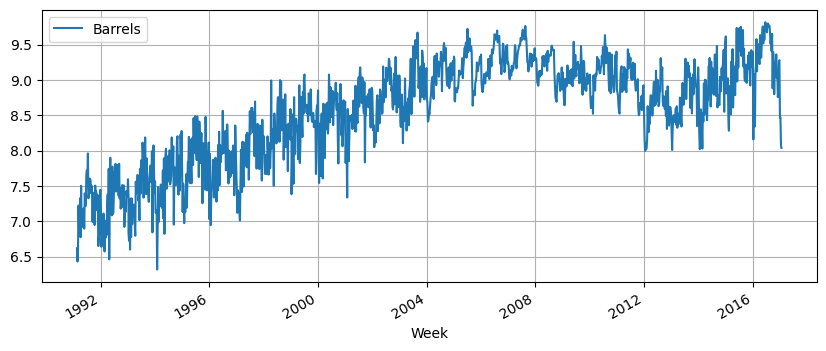

In [30]:
df = pd.read_csv("../data/us_gasoline.csv", index_col=[0])

df["Week"] = pd.to_datetime(
    df["Week"].apply(lambda x: x.replace(" W", "-") + '-0'),
    format="%Y-%W-%w"
)

df.plot(x="Week", grid=2, figsize=(10, 4));

In [41]:
forecast = pd.DataFrame(
    pd.date_range(
        start=df.Week.max(),
        end=df.Week.max() + pd.offsets.DateOffset(years=3),
        freq="W"
    )[1:]
).rename(columns={0: "Week"})

In [86]:
u = sm.tsa.UnobservedComponents(
    endog=df["Barrels"].to_numpy(),
    level=True,
    trend=True,
    irregular=False,
    autoregressive=10,
    damped_cycle=True,
    stochastic_level=False,
    stochastic_trend=False,
    freq_seasonal=[
        {"period": 53,
         "harmonics": 6}
    ]
).fit(disp=0)

f = u.get_forecast(steps=len(forecast))
fs, confs = f.predicted_mean, f.conf_int(alpha=0.05)

df["fitted"] = u.fittedvalues

forecast["Barrels"] = f.predicted_mean
forecast["lower"], forecast["upper"] = confs[:, 0], confs[:, 1]

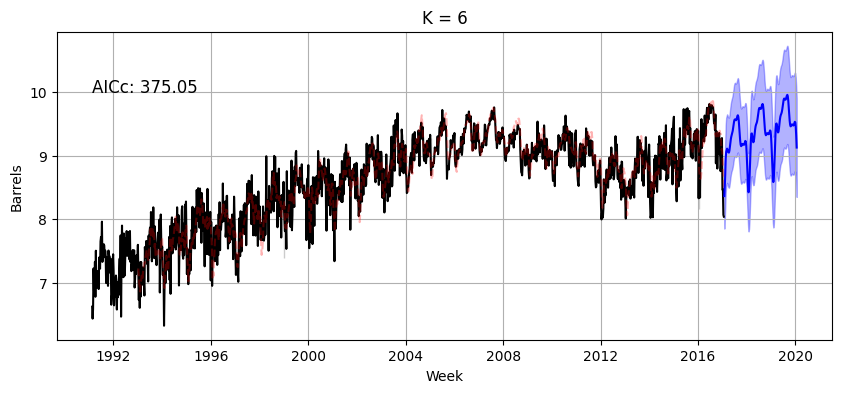

In [90]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(data=df, x="Week", y="Barrels", ax=ax, color="k")
sns.lineplot(data=df.iloc[100:, :], x="Week", y="fitted", ax=ax, color="r", linestyle="--", alpha=0.3)
sns.lineplot(data=forecast, x="Week", y="Barrels", ax=ax, color="b")
ax.fill_between(forecast["Week"], forecast["lower"], forecast["upper"], color="b", alpha=.3)
ax.set_title(f"K = {6}")
ax.text(
    x=ax.get_xaxis().get_data_interval()[0],
    y=10.0,
    s=f"AICc: {u.aicc:.2f}",
    fontsize=12
)
ax.grid(2)

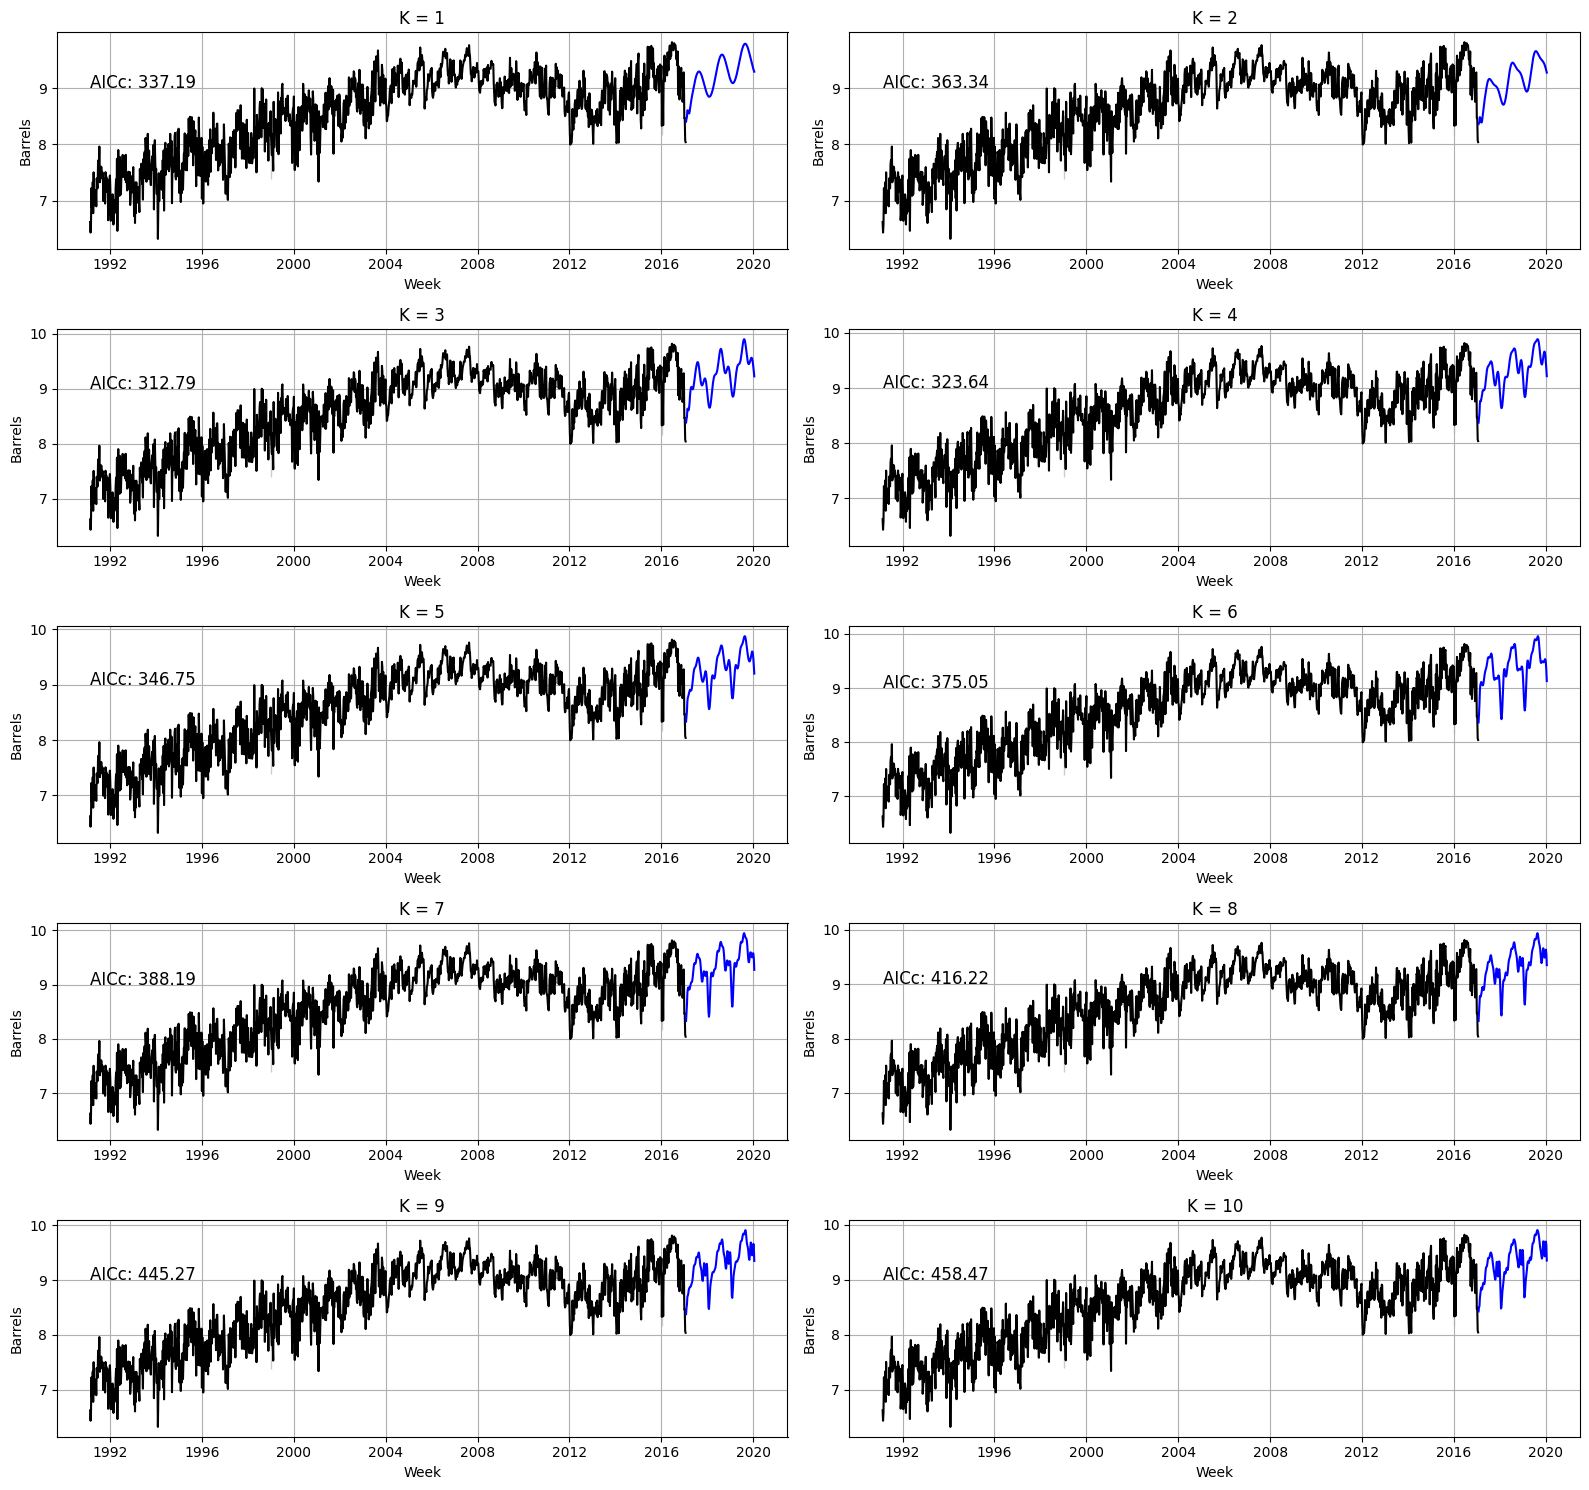

In [91]:
fig, ax = plt.subplots(5, 2, figsize=(16, 15))
ax = ax.flatten()

for axi, k in zip(ax, range(1, len(ax) + 1)):
    u = sm.tsa.UnobservedComponents(
        endog=df["Barrels"].to_numpy(),
        level=True,
        trend=True,
        irregular=False,
        autoregressive=10,
        damped_cycle=True,
        stochastic_level=False,
        stochastic_trend=False,
        freq_seasonal=[
            {"period": 53,
            "harmonics": k}
        ]
    ).fit(disp=0)

    f = u.get_forecast(steps=len(forecast))
    fs, confs = f.predicted_mean, f.conf_int(alpha=0.05)
    fs2, confs2 = f.predicted_mean, f.conf_int(alpha=0.2)

    forecast["Barrels"] = f.predicted_mean
    forecast["lower-95"], forecast["upper-95"] = confs[:, 0], confs[:, 1]
    forecast["lower-95"], forecast["upper-95"] = confs[:, 0], confs[:, 1]
    forecast["lower-80"], forecast["upper-80"] = confs2[:, 0], confs2[:, 1]
    forecast["lower-80"], forecast["upper-80"] = confs2[:, 0], confs2[:, 1]

    sns.lineplot(data=df, x="Week", y="Barrels", ax=axi, color="k")
    sns.lineplot(data=forecast, x="Week", y="Barrels", ax=axi, color="b")
    #axi.fill_between(forecast["Week"], forecast["lower-95"], forecast["upper-95"], color="b", alpha=.3)
    #axi.fill_between(forecast["Week"], forecast["lower-80"], forecast["upper-80"], color="k", alpha=.3)
    axi.set_title(f"K = {k}")
    axi.text(
        x=axi.get_xaxis().get_data_interval()[0],
        y=9.0,
        s=f"AICc: {u.aicc:.2f}",
        fontsize=12
    )

for axi in ax: axi.grid(2)
plt.tight_layout()

In [99]:
df["fitted"] = u.fittedvalues

dff = df.iloc[50:, :].reset_index(drop=True)

In [105]:
a = pm.auto_arima(
    y=dff[["Barrels"]],
    X=dff[["fitted"]],
    stepwise=False
)

a.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 1305
Model:               SARIMAX(0, 1, 1)   Log Likelihood                 -94.761
Date:                Wed, 27 Dec 2023   AIC                            197.522
Time:                        09:08:22   BIC                            218.214
Sample:                             0   HQIC                           205.284
                               - 1305                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0003      0.000      1.550      0.121   -8.82e-05       0.001
fitted         0.7456      0.031     23.727      0.000       0.684       0.807
ma.L1         -0.9721      0.009   -106.489      0.000      -0.990      -0.954
sigma2         0.0676      0.002     29.931      0.000       0.063       0.072
===================================================================================
Ljung-Box (L1) (Q):                   0.02   Jarque-Bera (JB):                47.75
Prob(Q):                              0.88   Prob(JB):                         0.00
Heteroskedasticity (H):               0.61   Skew:                            -0.20
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

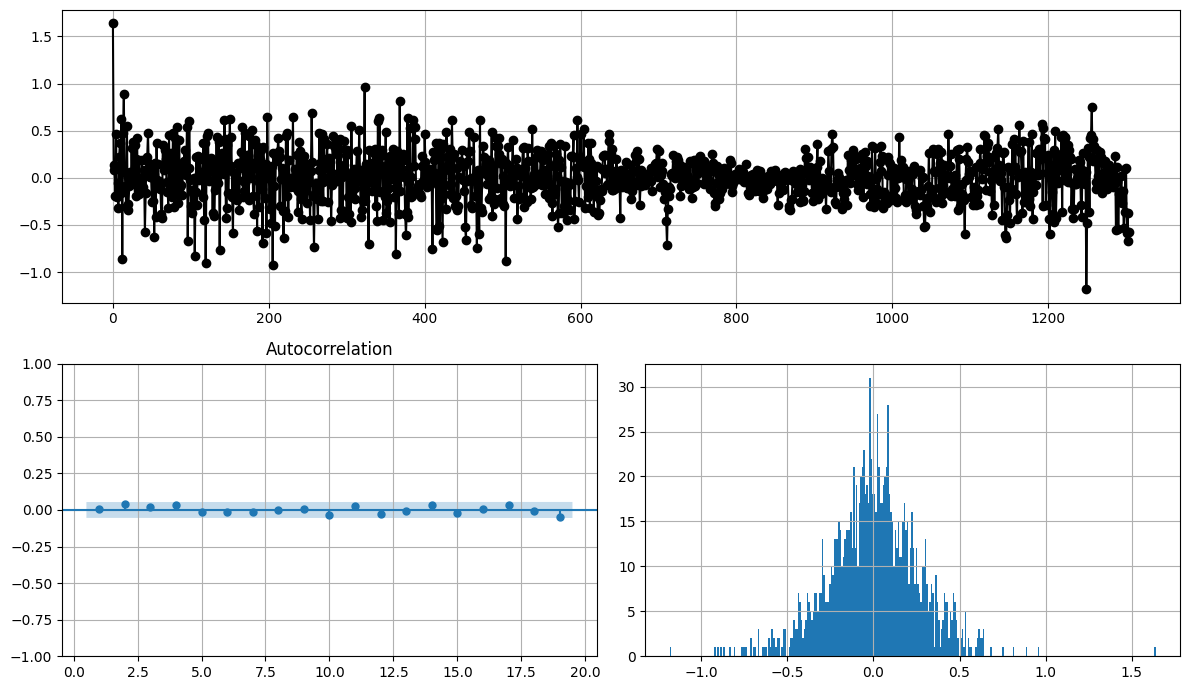

In [107]:
dff["resid"] = a.resid()
plot_ts_resid(dff, "Week", "resid", n_lags=range(1, 20))

#### 1.6. Lagged Prediction

Algumas coisas que impactam a variável resposta podem não estarem incluidas no modelo.

"Sometimes a change in $x_t$ does not affect $y_t$ instantaneously".

1. $y_t$ = sales, $x_t$ = advertising.
2. $y_t$ = stream flow, $x_t$ = rainfall.
3. $y_t$ = size of heard, $x_t$ = breeding stock.

Nessas situações precisamos incluir variáveis "lagadas" ou atrassadas das preditoras, é póssível escrever isso com a seguinte fórmula:

$y_t = \beta_0 + \gamma_0x_t + \gamma_1 x_{t-1} + \dots + \gamma_k x_{t-k} + \eta_t$

Onde no modelo incluimos as variáveis lagadas das preditoras.

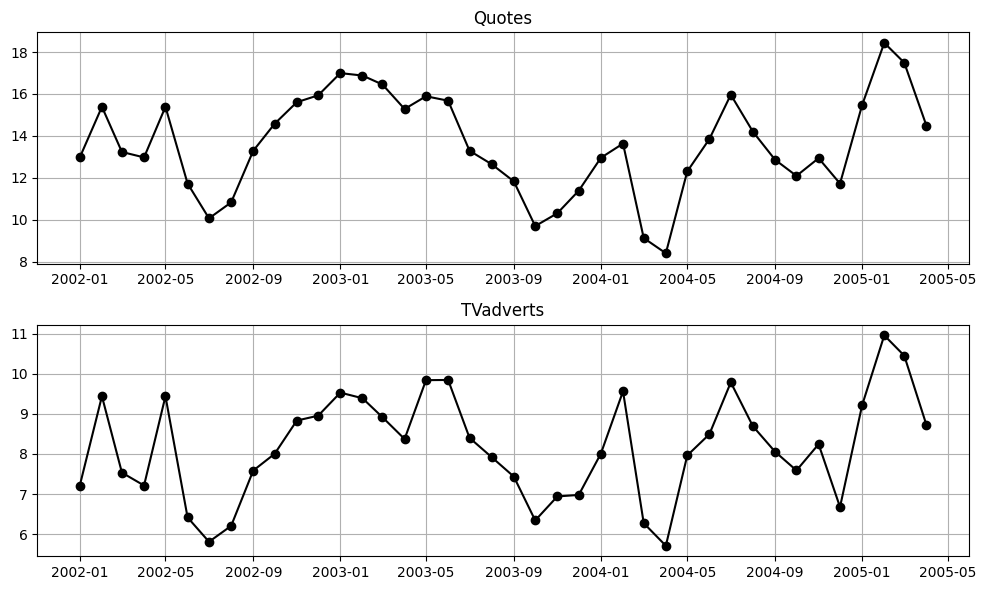

In [55]:
df = pd.read_csv("../data/insurance.csv", index_col=[0])

df["Month"] = pd.to_datetime(df["Month"], format="%Y %b")

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(df["Month"], df["Quotes"], color="k", marker="o")
ax[1].plot(df["Month"], df["TVadverts"], color="k", marker="o")

for axi, l in zip(ax, ["Quotes", "TVadverts"]): axi.grid(2); axi.set_title(l)

plt.tight_layout()

In [56]:
for i in range(1, 4):
    df[f"lag_{i}"] = df["TVadverts"].shift(i)

df.dropna(inplace=True)
df.reset_index(inplace=True, drop=True)

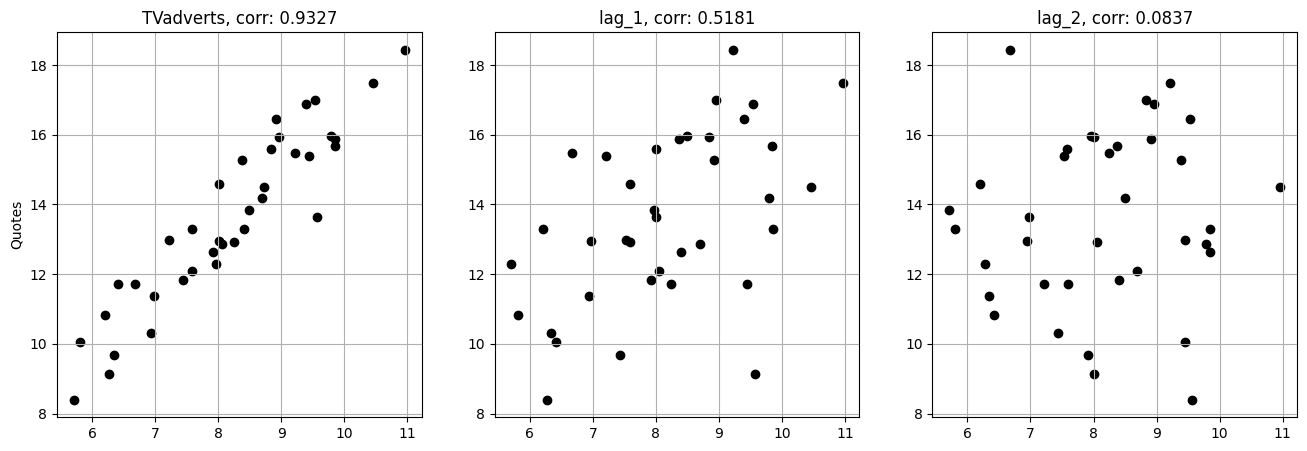

In [57]:
fig, ax = plt.subplots(1, 3, figsize=(16, 5))
ax = ax.flatten()

for i, var in zip(range(0, 3), ["TVadverts", "lag_1", "lag_2"]):
    ax[i].scatter(df[var], df["Quotes"], color="k")
    ax[i].set_title(f"{var}, corr: {df[[var, 'Quotes']].corr().iloc[-1, 0]:.4f}")
    ax[i].grid()

ax[0].set_ylabel("Quotes");

In [60]:
features = [
    ["TVadverts"],
    ["TVadverts", "lag_1"],
    ["TVadverts", "lag_1", "lag_2"],
    ["TVadverts", "lag_1", "lag_2", "lag_3"]
]

In [69]:
fit = [
    pm.auto_arima(
        y=df[["Quotes"]],
        X=df[feat],
        d=0
    )
    for feat in features
]

In [83]:
for f in fit:
    print("-"*78)
    print(f.summary())

------------------------------------------------------------------------------
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   37
Model:               SARIMAX(1, 0, 2)   Log Likelihood                 -27.228
Date:                Wed, 27 Dec 2023   AIC                             66.457
Time:                        11:32:52   BIC                             76.122
Sample:                             0   HQIC                            69.864
                                 - 37                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7059      0.756      2.256      0.024       0.224       3.188
TVadverts      1.1832      0.077     15.439      0.0

In [98]:
pd.DataFrame([{"aicc": f.aicc(), "aic": f.aic(), "bic": f.bic()} for f in fit]).reset_index().rename(columns={"index": "lag"})

,lag,aicc,aic,bic
0,0,69.256673,66.456673,76.122181
1,1,60.023572,58.088088,66.142678
2,2,63.256698,59.394629,70.671055
3,3,65.457469,60.314612,73.201955


In [104]:
fit[1].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                   37
Model:               SARIMAX(1, 0, 1)   Log Likelihood                 -24.044
Date:                Wed, 27 Dec 2023   AIC                             58.088
Time:                        11:37:41   BIC                             66.143
Sample:                             0   HQIC                            60.928
                                 - 37                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
TVadverts      1.3770      0.053     25.915      0.000       1.273       1.481
lag_1          0.2745      0.046      5.924      0.000       0.184       0.365
ar.L1          0.6718      0.205      3.283      0.001       0.271       1.073
ma.L1          0.6713      0.176      3.824      0.000       0.327       1.015
sigma2         0.2038      0.058      3.514      0.000       0.090       0.317
===================================================================================
Ljung-Box (L1) (Q):                   0.05   Jarque-Bera (JB):                12.54
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.00   Skew:                            -1.11
Prob(H) (two-sided):                  1.00   Kurtosis:                         4.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [162]:
forecast = pd.DataFrame(
    pd.date_range(
        start=df.Month.max(),
        end=df.Month.max() + pd.DateOffset(months=5),
        freq="MS"
    )[1:]
).rename(columns={0: "Month"})

# TVadverts
adv = 8.0
forecast["Adv"] = adv
forecast["Lag1"] = forecast["Adv"].shift(1).fillna(method="backfill")

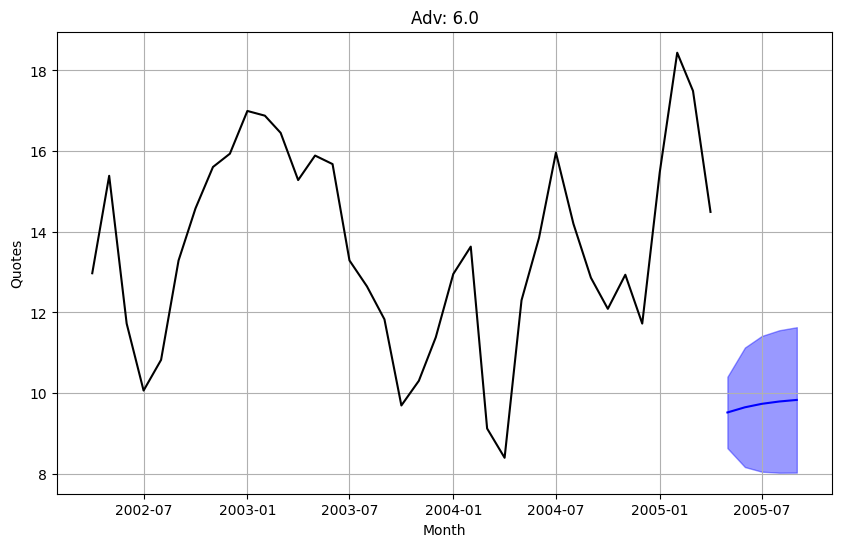

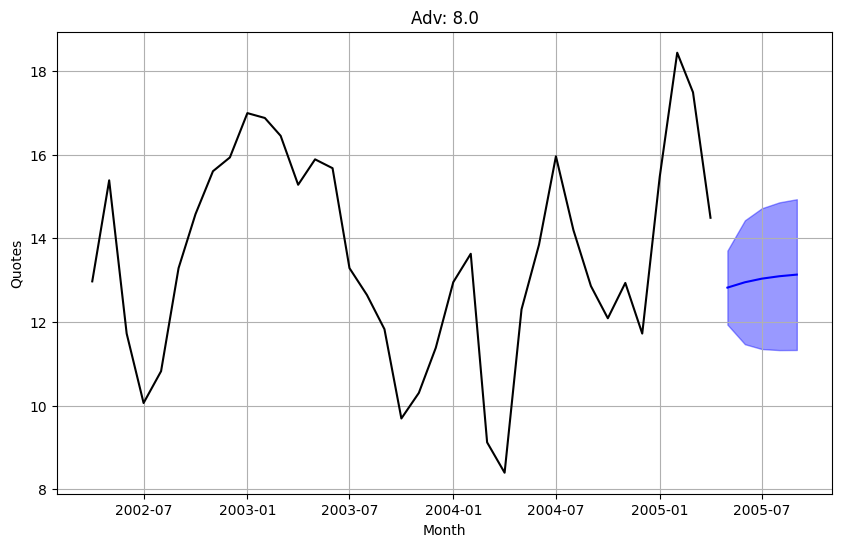

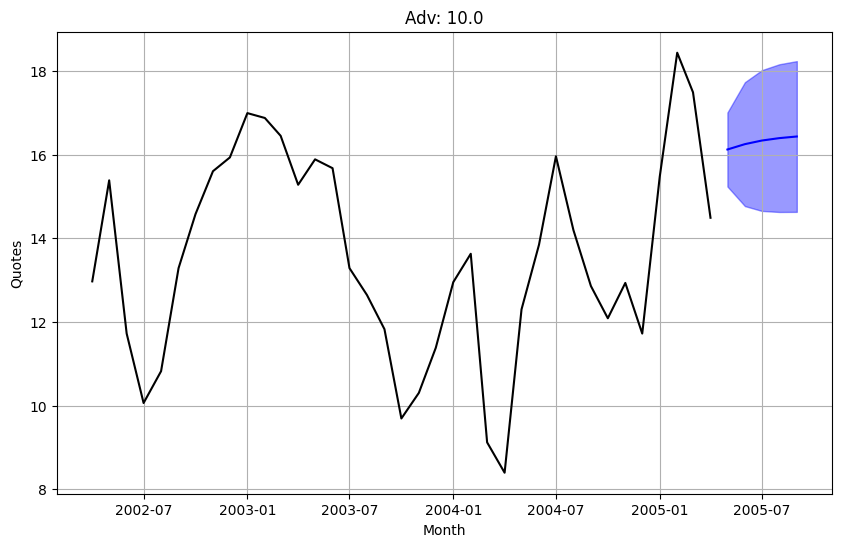

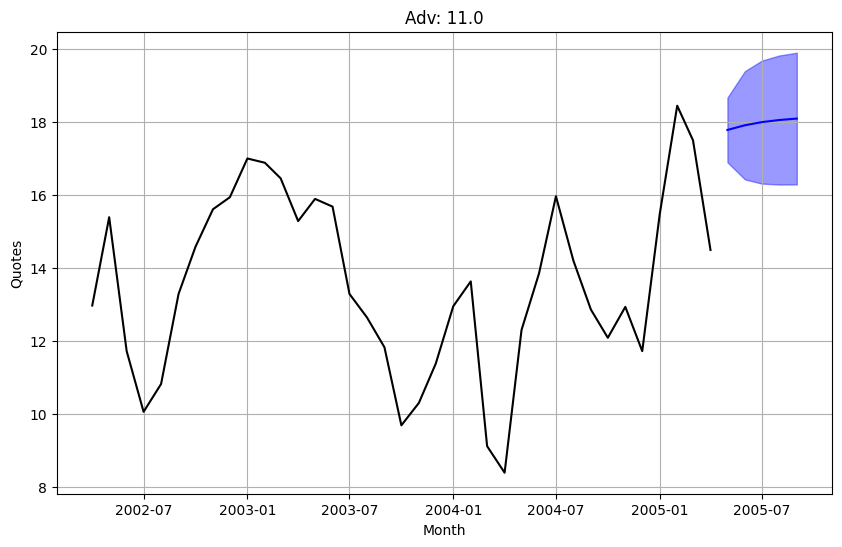

In [198]:
for adv in [6.0, 8.0, 10.0, 11.0]:
    forecast["Adv"] = adv
    forecast["Lag1"] = forecast["Adv"].shift(1).fillna(method="backfill")

    f, confs = fit[1].predict(
        len(forecast),
        X=forecast[["Adv", "Lag1"]],
        alpha=0.05,
        return_conf_int=True
    )

    forecast["Quotes"] = f.values
    forecast["lower"] = confs[:, 0]
    forecast["upper"] = confs[:, 1]

    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(df, x="Month", y="Quotes", ax=ax, color="k")
    sns.lineplot(forecast, x="Month", y="Quotes", ax=ax, color="b")
    ax.fill_between(forecast["Month"], forecast["lower"], forecast["upper"], color='b', alpha=0.4)
    ax.set_title(f"Adv: {adv}")
    ax.grid(2)